# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from dl4cv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


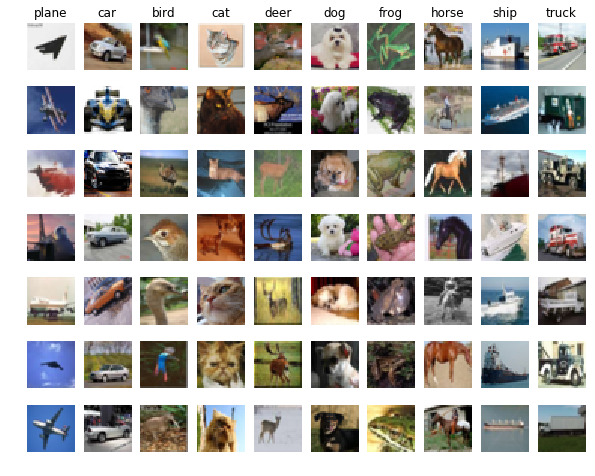

In [2]:
from dl4cv.data_utils import load_CIFAR10
from dl4cv.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from dl4cv.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 48000 images
Done extracting features for 2000 / 48000 images
Done extracting features for 3000 / 48000 images
Done extracting features for 4000 / 48000 images
Done extracting features for 5000 / 48000 images
Done extracting features for 6000 / 48000 images
Done extracting features for 7000 / 48000 images
Done extracting features for 8000 / 48000 images
Done extracting features for 9000 / 48000 images
Done extracting features for 10000 / 48000 images
Done extracting features for 11000 / 48000 images
Done extracting features for 12000 / 48000 images
Done extracting features for 13000 / 48000 images
Done extracting features for 14000 / 48000 images
Done extracting features for 15000 / 48000 images
Done extracting features for 16000 / 48000 images
Done extracting features for 17000 / 48000 images
Done extracting features for 18000 / 48000 images
Done extracting features for 19000 / 48000 images
Done extracting features for 20000 / 48000 images
Done extr

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from dl4cv.classifiers.linear_classifier import Softmax



learning_rates = [3.5e-6]
regularization_strengths = [0.8, 1, 5]

results = {}
best_val = -1
best_softmax = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. You might also want to play      #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        
        softmax = Softmax()
        softmax.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=2000,
                       verbose=False)
        y_train_pred = softmax.predict(X_train_feats)
        y_val_pred = softmax.predict(X_val_feats)
        train_acc=np.mean(y_train == y_train)
        val_acc=np.mean(y_val == y_val_pred)
        
        if val_acc>best_val:
            best_val=val_acc
            best_softmax=softmax
            
        results[(lr, rs)]=train_acc, val_acc 
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 3.500000e-06 reg 8.000000e-01 train accuracy: 1.000000 val accuracy: 0.401000
lr 3.500000e-06 reg 1.000000e+00 train accuracy: 1.000000 val accuracy: 0.379000
lr 3.500000e-06 reg 5.000000e+00 train accuracy: 1.000000 val accuracy: 0.390000
best validation accuracy achieved during validation: 0.401000


In [5]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.365


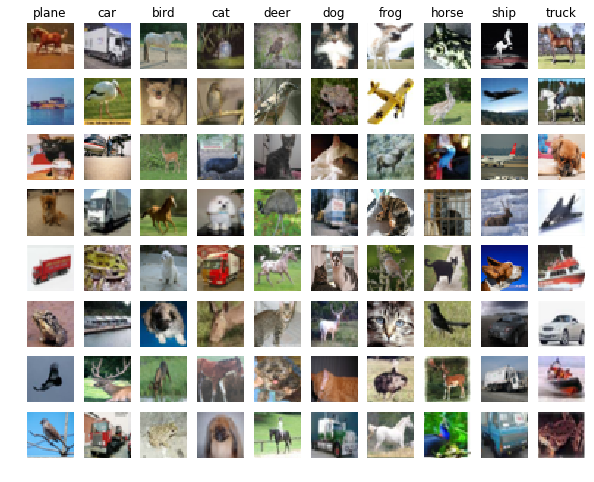

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [21]:
from dl4cv.classifiers.neural_net import TwoLayerNet
from dl4cv.classifiers.neural_net_deep import ThreeLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

results = {}
best_val = -1
best_stats=None
all_classifiers = []

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# Train the network
#stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
#num_iters=5000, batch_size=256,
#learning_rate=0.9, learning_rate_decay=0.95,
#reg=1e-3, verbose=True)

# Predict on the validation set
#val_acc = (net.predict(X_val_feats) == y_val).mean()
#print('Validation accuracy: ', val_acc)

#best_net = net

learning_rates = [6e-1]
regularization_strengths = [5e-4, 1e-4, 5e-5, 1e-3]



for lr in learning_rates:
    for rs in regularization_strengths:
        
        hidden_size = 500
        num_classes = 10
        #input_size = 32 * 32 * 3
        net = TwoLayerNet(input_dim, hidden_size, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=500,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rs, verbose=False)
        
        
        y_train_pred = net.predict(X_train_feats)
        y_val_pred = net.predict(X_val_feats)
        train_acc=np.mean(y_train == y_train_pred)
        val_acc=np.mean(y_val == y_val_pred)
        
        if val_acc>best_val:
            best_stats=stats
            best_val=val_acc
            best_net=net
            
        results[(lr, rs)]=train_acc, val_acc 
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, rs, train_acc, val_acc))

# Print out results.
for (lr, reg) in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    #print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 6.000000e-01 reg 8.000000e-04 train accuracy: 0.857042 val accuracy: 0.607000
lr 6.000000e-01 reg 2.000000e-03 train accuracy: 0.788250 val accuracy: 0.626000
lr 6.000000e-01 reg 1.000000e-03 train accuracy: 0.842708 val accuracy: 0.610000
lr 6.000000e-01 reg 1.000000e-02 train accuracy: 0.598833 val accuracy: 0.582000
best validation accuracy achieved during validation: 0.626000


In [22]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.555


## Save the model

When you are satisfied with your training, save the model for submission.

In [20]:
from dl4cv.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.59 \\
        \left(\frac{59}{\exp(0.59 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.59 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

In [ ]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.59, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()